In [1]:
import re
import numpy as np
from scipy import spatial
import sys
import time
import os

import matplotlib.pyplot as plt

# NLTK functions.
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# For extracting text from an URL.
import urllib
from bs4 import BeautifulSoup


stops = stopwords.words("english")         # For the list of stop words.
tokenizer = RegexpTokenizer(r'\w+')        # Tokenizer.
wordnet_lemmatizer = WordNetLemmatizer()   # Lemmatizer. 

gloveSize = 300                            # Dimensionality of the embedding space. 
embeddingPath = "/Users/Arvi/Downloads/"   # Folder where you put the embedding file. 
gloveFile = "glove.42B.300d.txt"           # Embedding data file.
#gloveFile = "/Users/Arvi/glove.6B/glove.6B.50d.txt"

/Users/Arvi/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#
#    Some functions to get data, and clean it.
#

def getText(url):
  html = urllib.urlopen(url).read()
  soup = BeautifulSoup(html, 'html.parser')
  for script in soup(["script", "style"]):
    script.extract()

  text = soup.get_text()
  lines = (line.strip() for line in text.splitlines())
  chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
  text = '\n'.join(chunk for chunk in chunks if chunk)
  text = text.encode('utf-8')

  cleaned_text = ""
  for v in text:
    if v.lower() in "-_/\'.,;abcdefghijklmnopqrstuvwxyz \n":
      cleaned_text += v
  return cleaned_text      



def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def getCleanedData(files):

  def getData(text):
    tmp = text.split("\n")
    cleaned1 = ""
    for t in tmp:
      c = len(t.split())
      if c > 9:
        cleaned1 += t
    
    tokens = tokenizer.tokenize(cleaned1.lower())
    stopped_tokens = [i for i in tokens if not i in stops]
    stopped_tokens2 = []
    for token in stopped_tokens:
      s = ""  
      for c in token:
        if c == '': continue
        if c.lower() in "abcdefghijklmnopqrstuvwxyz-.,/\?_'":
          s += c
      stopped_tokens2.append(s)    

    tokens = [str(wordnet_lemmatizer.lemmatize(i)) for i in stopped_tokens2 if len(i) > 0]
    return tokens

  data = []
  for f in files:
    data.append(open(path+f).read())
  
  cleanedData = []
  for d in data:
    t = getData(d)
    s = ""
    for y in t:
      s += y + ' '
    s = s[:-1]  
    if len(s.split()) >= 50:
      cleanedData.append(s)

  return cleanedData      


def cleanAgain(d):
  def getData(text):
    tmp = text.split("\n")
    cleaned1 = ""
    for t in tmp:
      c = len(t.split())
      if c > 9:
        cleaned1 += t
    
    tokens = tokenizer.tokenize(cleaned1.lower())
    stopped_tokens = [i for i in tokens if not i in stops]
    stopped_tokens2 = []
    for token in stopped_tokens:
      s = ""  
      for c in token:
        if c == '': continue
        if c.lower() in "abcdefghijklmnopqrstuvwxyz-.,/\?_'":
          s += c
      stopped_tokens2.append(s)    

    tokens = [str(wordnet_lemmatizer.lemmatize(i)) for i in stopped_tokens2 if len(i) > 0]
    return tokens

  t = getData(d)
  s = ""
  for y in t:
    s += y + ' '
  s = s[:-1]  

  return s

In [3]:
#
#    Global data.
#    
path = "/Users/Arvi/choosito/data/familiarity/text/"

t1 = time.time()
files = os.listdir(path)
data = getCleanedData(files)

A = {}
for d in data:
  for w in d.split():    
    if w.lower() not in A: A[w.lower()] = True
vocab = A.keys()

lu = {}
for w in vocab: lu[w] = 0.
for d in data:
  words = d.split()
  K = 1./len(words)
  for w in words:
    lu[w] += K
    
t2 = time.time()    
print "Number of URLs:",len(files)
print "Vocabulary size:", len(vocab)
print "Took",(t2-t1)*1./60,"minutes."

/Users/Arvi/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:53: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Number of URLs: 3038
Vocabulary size: 107100
Took 2.37550083399 minutes.


In [4]:
# This is P[keyword | Document] summed over documents, so can be greater than 1.0
print lu["book"]
print lu["wine"]
print lu["empty"]
print lu["pancreatitis"]

2.33355380065
0.744684622677
0.137848577688
9.84736582964e-05


In [5]:
#
#   Load embeddings into a dictionary.
#
def loadGloveModel(gloveFile):
  f = open(gloveFile,'r')
  model = {}
  for line in f:
    splitLine = line.split()
    word = splitLine[0]
    embedding = [float(val) for val in splitLine[1:]]
    model[word] = embedding

  f.close()        
  return model

In [6]:
t1 = time.time()
model = loadGloveModel(embeddingPath+gloveFile)
t2 = time.time()
print "Embeddings loaded, took",(t2-t1)*1./60., "minutes"

Embeddings loaded, took 5.63277851741 minutes


In [7]:
#
#     Construct topic vectors.
#     text:    Text that you want vectorized.
#     k:   Number of words that form a topic.
#     Wt:  Dictionary of weights for each word.
#
def vectorizeText_k(text,k,Wt):
  
  def getDocVecs(doc1,k,Wt):
  
    def getDocVec(s,Wt):
  
      docVec = [0]*gloveSize
      ctr = 0.
      for word in s.split():
        w = word.strip()
        if w != ',' and w != ';' and w != '.':      
          if w in model:
            weight = 1.
            if w in Wt: weight = Wt[w]
            for i in range(0,gloveSize):      
              docVec[i] += (model[w][i] * weight)
            ctr += weight  
      
      if ctr > 0.:    
        for i in range(0,gloveSize):
          docVec[i] = docVec[i]*1./ctr
    
      return docVec

  
    A = [v.rstrip() for v in doc1.split('.')]
    s = ""
    for sent in A:
      words = [x for x in sent.split() if x.lower() not in stops]
      sentence = ""
      for word in words:
        sentence += word + " "
      s += clean_str(sentence) + " "
  
    t = [v for v in s.split() if v != ',' and v not in "0123456789"]
    if len(t) < k:
      t += (" "*(k-len(t)))  
    L = int(len(t)//k)
    subs = []
    for i in range(0,L):
      st = ""
      for v in t[i*k:(i+1)*k]:
        st += v + " "
      subs.append(st)
  
    docVecs = []
    for i in range(0,L):
      docVecs.append(getDocVec(subs[i],Wt))
    
    return docVecs


  ct = k
  if ct > len(text.split()): ct = len(text)   
  if len(text) == 0: V = [0]*gloveSize   
  else: V = getDocVecs(text,ct,Wt)
  return V

In [8]:
#
#  Get the Bayes weights.
#
def getWeights(text,glob):

  words = text.split()
  K = 1./len(words)

  uDict = {}
  for w in words:
    if w in uDict: uDict[w] += K
    else: uDict[w] = K  

  bayes = {}
  for w in uDict.keys():
    if w not in glob: ct = 0.
    else: ct = glob[w]  
    bayes[w] = uDict[w] / ( uDict[w] + ct )
  
  return bayes

In [9]:
#
#    Training URL.
#
url = "https://en.wikipedia.org/wiki/French_wine"  
os.system("python get_text.py " + url + " > temp")        
text = open("temp").read() 
text = cleanAgain(text)

W = getWeights(text,lu)

In [10]:
print W["region"]
print W["wine"]    
print W["vineyard"] 
print W["sauvignon"]  

0.00827784913376
0.0821674502059
0.118447534452
0.471070766912


In [11]:
# Get topic vectors.
sizes = [50,100,200,400,len(text)]
vec = []
for lp in sizes:
  vec.append(vectorizeText_k(text,lp,W))    

In [12]:
#
#   Max-pooled cosine similarity scores, stride = topic length.
#
def testMatch(testVec,V):

  C = []
  for lp in range(0,5):  
    A = []
    for i in range(0,np.shape(V[lp])[0]):
      B = []
      for j in range(0,np.shape(testVec[lp])[0]):
        cs = 1. - spatial.distance.cosine(V[lp][i],testVec[lp][j])
        if np.isnan(cs): cs = 0.      
        B.append(cs)
      A.append(np.mean(B))  

    print lp,np.max(A)  
    C.append(np.max(A))
  return C    

In [13]:
testUrls = [
  "http://drinks.seriouseats.com/2014/02/french-wine-for-beginners-what-is-burgundy-bordeaux-essential-wine-regions-grapes-in-france-basics.html",   
  "http://www.slate.com/articles/life/drink/2009/07/two_cheers_for_france.html",   
  "https://en.wikipedia.org/wiki/Champagne",
  "http://www.taylor.pt/en/what-is-port-wine/introduction/",
  "https://en.wikipedia.org/wiki/Sonoma_County_wine",
  
  "https://en.wikipedia.org/wiki/Algebra",
  "https://en.wikipedia.org/wiki/Complex_number",
  "http://www.classical.net/music/comp.lst/beethoven.php",
  "http://www.dailymail.co.uk/tvshowbiz/article-1034466/Is-Abbas-Agnetha-Faltskog-finally-ready-forgive-bandmates-years-misery.html",
  "http://www.theatlantic.com/magazine/archive/2016/06/the-mind-of-donald-trump/480771/",   
  
  "https://en.wikipedia.org/wiki/TGV",
  "http://www.aparisguide.com/champs-elysees/",
  "https://en.wikipedia.org/wiki/Chamonix",
  "https://en.wikipedia.org/wiki/Louvre",
  "https://en.wikipedia.org/wiki/Paris"

  
  ]

B = []
for url in testUrls:
  print url
  os.system("python get_text.py " + url + " > temp")
  text = open("temp").read() 
  text = cleanAgain(text)

  W = getWeights(text,lu)
  sizes = [50,100,200,400,len(text)]    
  testVec = []
  for lp in sizes:
    testVec.append(vectorizeText_k(text,lp,W))    
    
  B.append(testMatch(testVec,vec))

http://drinks.seriouseats.com/2014/02/french-wine-for-beginners-what-is-burgundy-bordeaux-essential-wine-regions-grapes-in-france-basics.html
0 0.654288675234
1 0.748876839027
2 0.794506633276
3 0.866242697264
4 0.916051515425
http://www.slate.com/articles/life/drink/2009/07/two_cheers_for_france.html
0 0.601132508327
1 0.699650475872
2 0.813578009758
3 0.89727175983
4 0.898832262706
https://en.wikipedia.org/wiki/Champagne
0 0.601453507672
1 0.640269697854
2 0.696938465282
3 0.680822150246
4 0.718621566982
http://www.taylor.pt/en/what-is-port-wine/introduction/
0 0.62114703571
1 0.680490360117
2 0.742657368547
3 0.761156535272
4 0.723513433191
https://en.wikipedia.org/wiki/Sonoma_County_wine
0 0.714731232958
1 0.795233131896
2 0.811225691288
3 0.807413592385
4 0.768433389041
https://en.wikipedia.org/wiki/Algebra
0 0.0688870099546
1 0.0723004088468
2 0.0431752849917
3 0.0303817817819
4 -0.0227919649423
https://en.wikipedia.org/wiki/Complex_number
0 0.168449414089
1 0.131548374186
2 0.14

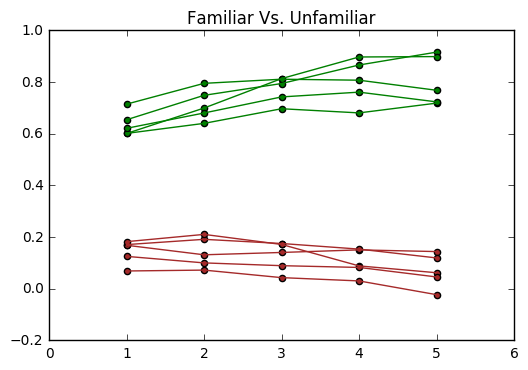

In [14]:
colo = ['green', 'green', 'green', 'green', 'green', 'brown', 'brown','brown','brown','brown']
for lp in range(0,10):
  plt.scatter([1,2,3,4,5],B[lp],c=colo[lp])
  plt.plot([1,2,3,4,5],B[lp],c=colo[lp])
  plt.title ("Familiar Vs. Unfamiliar")
plt.show()

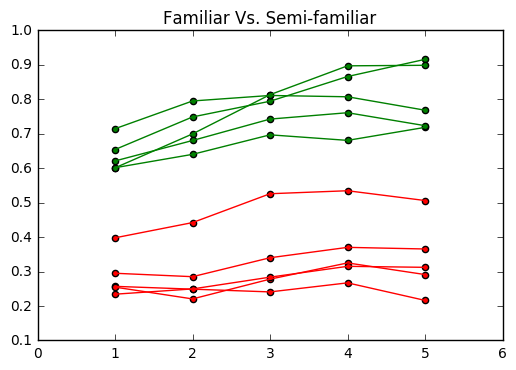

In [15]:
colo = ['green', 'green', 'green', 'green', 'green', 'brown','brown','brown','brown','brown',  'red','red','red','red','red']     
for lp in [0,1,2,3,4,10,11,12,13,14]:
  plt.scatter([1,2,3,4,5],B[lp],c=colo[lp])
  plt.plot([1,2,3,4,5],B[lp],c=colo[lp])
  plt.title ("Familiar Vs. Semi-familiar")
plt.show()

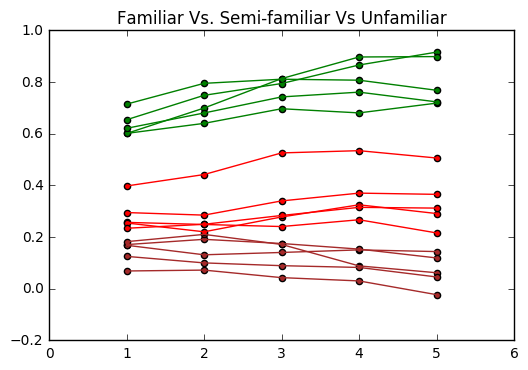

In [16]:
colo = ['green', 'green', 'green', 'green', 'green', 'brown','brown','brown','brown','brown',  'red','red','red','red','red']     
for lp in range(0,15):
  plt.scatter([1,2,3,4,5],B[lp],c=colo[lp])
  plt.plot([1,2,3,4,5],B[lp],c=colo[lp])
  plt.title ("Familiar Vs. Semi-familiar Vs Unfamiliar")
  
plt.show()